<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.ops.parallel_for.gradients import jacobian
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [0]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
tf.reset_default_graph()

batch_size  = 256
hidden_size = 8

def inference(in_net):
    with tf.variable_scope('generator/inference', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 512, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 256, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 2*hidden_size, name='dense_5', activation=None)
    return net

def generator(in_net):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 256, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 512, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 784, name='dense_5', activation=None)
    return net

lr    = tf.placeholder_with_default(0.001,shape=[])

x     = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)

prior = tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0)

mu, sigma        = tf.split(inference(x), 2, axis=-1)
sigma            = tf.nn.softplus(sigma) + 0.0001
approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

z = approx_posterior.sample()

sample_size = tf.placeholder_with_default(100,shape=[])

z_samples = approx_posterior.sample(sample_size)

x_samples = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples))).sample(sample_size)



x_sims = tfd.Independent(tfd.Bernoulli(logits=generator( prior.sample(batch_size)))).sample(sample_size)

data_likelihood = tfd.Independent(tfd.Bernoulli(logits=generator(z)))

kl_divergence = tfd.kl_divergence(approx_posterior, prior)

elbo = - tf.reduce_mean(data_likelihood.log_prob(x) - kl_divergence,axis=0)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5,zoom_range=0.1)
#datagen.fit(x_train.reshape((50000,28,28,1))) only needed if data trafos depend on the data itself

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(elbo)

Instructions for updating:
Use tf.cast instead.


In [0]:
# with tf.Session() as sess:
#   # `sess.graph` provides access to the graph used in a <a href="./../api_docs/python/tf/Session"><code>tf.Session</code></a>.
#   writer = tf.summary.FileWriter("/tmp/log/...", sess.graph)

#   sess.run(tf.global_variables_initializer())
  
#   nepochs=10
#   for ep in range(nepochs):
#     gen = datagen.flow(x_train.reshape((50000,28,28,1)), batch_size=batch_size)
#     count = 0
#     print('new epoch')
    
#     for i in range(50000 // batch_size):
#         # Train the inference model
#         imgs = next(gen)
        
#         if len(imgs) < batch_size:
#             imgs = next(gen)
            
#         imgs = imgs.reshape([-1,784])

#         # Train the generative model
#         _, l  = sess.run([opt_op, elbo], feed_dict={x: imgs, lr:0.0001})
        
#         losses_data.append(l)
        
#         count += 1
#         if count % 10 ==0:
#             print(ep, l)

#   writer.close()

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())


In [0]:
losses_data = []

In [0]:
imgsv_full= x_valid.reshape((-1,28,28,1))
print(imgsv_full.shape)

(10000, 28, 28, 1)


In [0]:
nepochs     = 20
jj          = 0.
lrate_start = 1e-4
maxcount    = 10
ii          = 0

for ep in range(nepochs):
    gen  = datagen.flow(x_train.reshape((50000,28,28,1)), batch_size=batch_size)
    
    count = 0
    print('new epoch')
    lrate=lrate_start
    for i in range(50000 // batch_size):
        # Train the inference model
        imgs  = next(gen)

        imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]

        if (len(imgsv) < batch_size) or ((ii+1)*batch_size==len(imgsv_full)):
          ii=0
          imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]
        ii+=1
       
        
        if len(imgs) < batch_size:
            imgs = next(gen)

            
        imgs = imgs.reshape([-1,784])
        imgsv= imgsv.reshape([-1,784])

        # Train the generative model
        _, l  = sess.run([opt_op, elbo], feed_dict={x: imgs, lr:lrate})
        lv    = sess.run([elbo], feed_dict={x: imgsv})[0]
        
        if lv>l:
          jj+=1
        if l>lv:
          jj=0.
        
      
        losses_data.append(l)
        
        count += 1
        if count % 10 ==0:
            print(ep, l, lv, jj)
            
        if jj>maxcount:
            print('break criterion met')
            break
    if jj>(maxcount+5):
      break

new epoch
0 141.97063 126.14529 0.0
0 142.91653 131.38199 0.0
0 143.4365 132.08347 0.0
0 141.04318 126.07375 0.0
0 139.4747 124.934494 0.0
0 137.78046 124.33909 0.0
0 136.64247 127.78231 0.0
0 140.3715 133.68225 0.0
0 139.83011 134.0267 0.0
0 140.20972 129.86705 0.0
0 139.46225 128.52167 0.0
0 142.67511 131.28326 0.0
0 137.54457 127.41482 0.0
0 144.66112 129.87448 0.0
0 143.52927 134.25697 0.0
0 139.06505 121.79872 0.0
0 135.01874 127.16237 0.0
0 139.52432 126.638626 0.0


KeyboardInterrupt: ignored

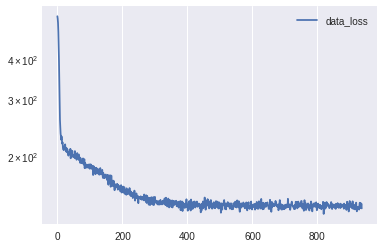

In [0]:
plot(losses_data,label='data_loss')
legend()
yscale('log')

In [0]:
res = sess.run(z, feed_dict={x: x_test[0:batch_size]})
labels = targets_test[0:batch_size]

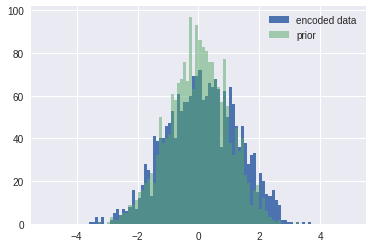

In [0]:
hist(res.flatten(),100,range=[-5,5],label='encoded data');
hist(randn(len(res.flatten())),100,range=[-5,5],alpha=0.5,label='prior');
legend()

(?, 256, 784)


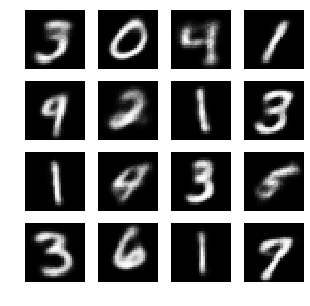

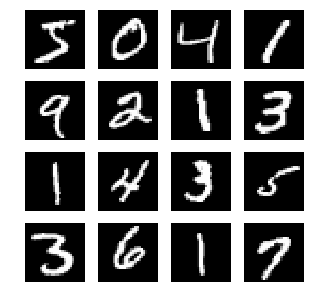

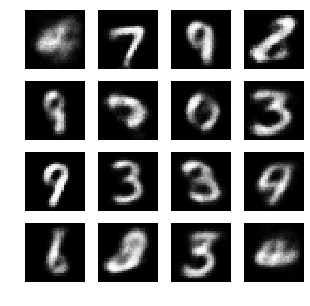

In [0]:
res, inim, s = sess.run([data_likelihood.mean(), x, x_sims], feed_dict={x: x_train[0:batch_size], sample_size: 400})
print(x_sims.shape)
figure(figsize=(5,5))
for i in range(16):
    subplot(4,4,i+1)
    imshow((res )[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(s[:,i,:].reshape((-1,28,28)),axis=0),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
mask = np.ones(IMAGE_SHAPE)
mask[0:28,13:16]=0

mask = mask.reshape((28*28))
mask = np.asarray([mask]*batch_size)
print(mask.shape)

(256, 784)


In [0]:
zs  = sess.run(z_samples, feed_dict={x: x_valid[0:batch_size], sample_size:1 })

In [0]:
zs =zs[0]
print(zs.shape)

(1, 256, 8)


In [0]:
masked_data = x_valid[0:batch_size]*mask

In [0]:
xs  = sess.run(x_samples, feed_dict={x: x_valid[0:batch_size], sample_size:10 })

In [0]:
xrecon  = sess.run(x_samples, feed_dict={x: masked_data, sample_size:20 })

In [0]:
print(xs.shape)

(10, 10, 256, 784)


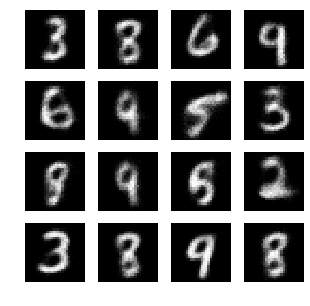

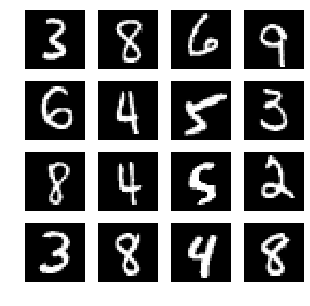

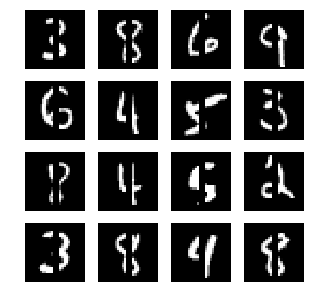

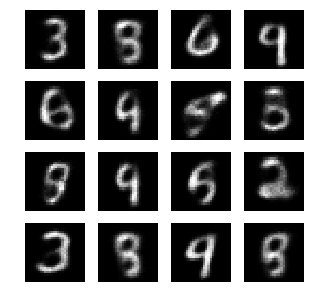

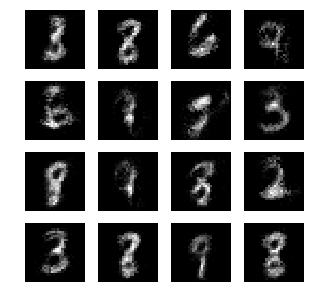

In [0]:
figure(figsize=(5,5))
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xs,axis=(0,1))[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
for i in range(16):
    subplot(4,4,i+1)
    imshow(x_valid[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
for i in range(16):
    subplot(4,4,i+1)
    imshow(masked_data[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
   
figure(figsize=(5,5))
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecon,axis=(0,1))[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
    
figure(figsize=(5,5))
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xs,axis=(0,1))[i].reshape((28,28))-np.mean(xrecon,axis=(0,1))[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

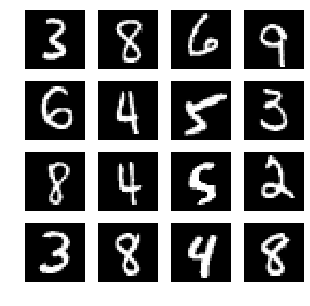